In [48]:
# supplementary figure lot variability

import numpy as np
import pandas as pd
import seaborn as sbn 
import matplotlib.pyplot as plt
from datetime import datetime

current_date = datetime.now()
formatted_date = current_date.strftime("%Y.%m.%d")

root = '/Users/grantongo/Desktop/nature methods'
figure_directory = '/Users/grantongo/Desktop/nature methods/figures/figure si.3 (lot variability)'

df = pd.read_csv(f'{root}/figures/figure si.7 (lot variability)/data_lot_variability.csv')
df.head()

,Unnamed: 0,experiment_id,reagent_lot,plate_id,date,CCL8,MIF,MMP-1,Tie-2,TNF alpha,...,Decorin,Thrombospondin-1,Neutrophil Elastase/ELA2,Galectin-1,Metalloproteinase inhibitor 2,Galectin-3,"Neutrophil gelatinase-associated lipocalin (NGAL, lipocalin-2)",soluble uPA-R,Angiopoietin-1,Transforming growth factor-beta-induced protein ig-h3
0,0,nEL2.5.201,Lot 1,1959,"February 7, 2024",NaN,652.877657,445.795512,592.708380,2740.843509,...,118.015286,112482.072063,656.717766,29721.723692,107.816784,2863.702037,72.116961,854.106402,257.929904,627.369745
1,1,nEL2.5.206,Lot 1,1997,"February 13, 2024",NaN,644.922907,517.485912,673.451473,2712.960238,...,103.704091,NaN,797.317501,29340.841750,104.407179,2877.468944,80.821188,857.453739,292.421640,608.027832
2,2,nEL2.5.207,Lot 1,2001,"February 14, 2024",NaN,697.153422,475.920266,549.751832,2755.705592,...,120.260879,NaN,654.718539,31025.055624,100.434446,2977.361734,73.300846,859.563393,276.547229,650.954222
3,3,nEL2.5.212,Lot 1,2064,"February 21, 2024",NaN,662.657233,505.237457,492.357043,2371.925230,...,98.424142,NaN,749.665069,26021.173961,99.737760,2396.499334,77.989533,830.849245,256.747614,591.276185
4,4,nEL2.5.217,Lot 1,2115,"February 27, 2024",NaN,691.314779,489.060350,434.735721,2477.464450,...,91.080769,NaN,814.699139,26084.788846,92.945683,2681.519223,73.990202,801.766109,256.920377,569.353567


In [49]:
df_group = df.drop(columns=['plate_id', 'date', 'experiment_id', 'Unnamed: 0'])
df_group = df_group.groupby('reagent_lot').agg(['mean', 'std']).reset_index()
df_group.columns = ['reagent_lot'] + ['_'.join(col).strip() for col in df_group.columns[1:]]

df_melt = pd.melt(df_group,
                  id_vars=['reagent_lot'],
                  var_name='metric',
                  value_name='value')
df_melt[['sensor', 'stat']] = df_melt['metric'].str.rsplit('_', n=1, expand=True)
df_melt = df_melt.drop(columns=['metric'])

df_stat = df_melt.pivot(index=['reagent_lot', 'sensor'], columns='stat', values='value').reset_index()
df_stat['cv'] = df_stat['std'] / df_stat['mean']

print(f'mean: {np.round(np.mean(df_stat["cv"]*100),2)}')
print(f'median: {np.round(np.nanmedian(df_stat["cv"]*100),2)}')
print(f'min cv: {np.round(np.min(df_stat["cv"]*100),2)}')
print(f'max cv: {np.round(np.max(df_stat["cv"]*100),2)}')

mean: 11.75
median: 8.66
min cv: 0.4
max cv: 70.47


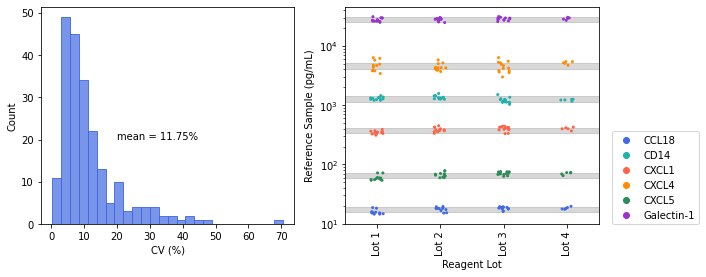

In [13]:
# figure

df_plot = pd.melt(df,id_vars=['reagent_lot','plate_id','date','experiment_id','Unnamed: 0'],
                  var_name=['sensor'],
                  value_name='value')
sensors_plot = ['CCL18','CXCL1','CXCL4','CXCL5','IL-1 RARN','CD14','Galectin-1']

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0] = sbn.histplot(df_stat['cv']*100, 
                  color='royalblue',
                  edgecolor = 'royalblue',
                  alpha=0.7,
                  ax=ax[0]
                 )

ax[0].set_ylabel('Count')
ax[0].set_xlabel('CV (%)')
ax[0].text(20,20,f'mean = {np.round(np.mean(df_stat["cv"]*100),2)}%')

ax[1] = sbn.stripplot(data = df_plot[df_plot.sensor.isin(sensors_plot)],
                   x='reagent_lot',
                   y='value',
                   hue='sensor',
                   s=3,
                   palette =['royalblue','lightseagreen','tomato','darkorange','seagreen','darkorchid'],
                   ax=ax[1])

for sensor in sensors_plot:
    mean_value = df_plot[df_plot['sensor'] == sensor]['value'].mean()
    lower_bound = mean_value - 0.1 * mean_value
    upper_bound = mean_value + 0.1 * mean_value
    plt.axhspan(lower_bound, upper_bound, color='grey', alpha=0.3)

ax[1].tick_params(axis='x', rotation=90)
ax[1].set_yscale("log")
ax[1].set_ylabel('Reference Sample (pg/mL)')
ax[1].set_xlabel('Reagent Lot')
ax[1].legend(loc=(1.05,0))

fig.savefig(f'{figure_directory}/svg_lot_variability_{formatted_date}.svg')